### Objectifs de ce notebook :
>Utilisation des données du site https://data.cityofchicago.org/ sur la criminalité

## Prédiction des crimes par type et par région 
- Le nombre de crime est vu comme une série temporelle
- Utilisation de la librairie PROPHET https://facebook.github.io/prophet/docs/quick_start.html
- Visualisation des résultats

In [1]:
%load_ext autoreload
%autoreload 2

### Import des package

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Box
from IPython.display import IFrame
from datetime import datetime
from scipy import stats

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)
import datetime
from pandas.tseries.offsets import MonthEnd

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [7]:
from datetime import datetime

## Chemin des données

In [8]:
Path_Socio = "/home/ml/Documents/crimes_chigaco/data/raw/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv"
Path_Crime = "/home/ml/Documents/crimes_chigaco/data/raw/Crimes_-_2001_to_present.csv"

## Chargment des données

In [9]:
df_Socio = pd.read_csv(Path_Socio)
df_Crime = pd.read_csv(Path_Crime, sep=';', parse_dates=['Date'])

In [10]:
def rename_columns_socio():
    """
    
    """
    return {
'Community Area Number':'community_area_number',
'COMMUNITY AREA NAME':'community_area_name', 
'PERCENT OF HOUSING CROWDED':'pct_housing_crowded', 
'PERCENT HOUSEHOLDS BELOW POVERTY':'pct_households_below_poverty', 
'PERCENT AGED 16+ UNEMPLOYED':'pct_age16_unemployed',
'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA':'pct_age25_no_highschool',
'PERCENT AGED UNDER 18 OR OVER 64': 'pct_not_working_age',
'per_capita_income':'per_capita_income',
'HARDSHIP INDEX' : 'hardship_index'}

def rename_columns_crimes():
    """
    
    """
    return {
        'ID': 'id',
        'Case Number': 'cas_number', 
        'Date':'date',
        'Block':'block', 
        'IUCR':'iucr', 
        'Primary Type':'primary_type',
        'Description':'description', 
        'Location Description':'location_description', 
        'Arrest':'arrest', 
        'Domestic':'domestic', 
        'Beat':'beat',
        'District':'district', 
        'Ward':'ward', 
        'Community Area': 'community_area_number', 
        'FBI Code':'fbi_code', 
        'X Coordinate':'x_coordinate',
        'Y Coordinate':'y_coordinate', 
        'Year':'year', 
        'Updated On':'updated_on', 
        'Latitude':'latitude', 
        'Longitude':'longitude',
        'Location':'location'   
    }

df_Socio.rename(columns=rename_columns_socio(), inplace=True)
df_Crime.rename(columns=rename_columns_crimes(), inplace=True)

In [11]:
df_src = pd.merge(df_Crime, df_Socio, on='community_area_number', how='left')
df_src.drop(df_src.columns.difference(['primary_type','date', 'community_area_name']), inplace=True, axis=1)

In [12]:
list_date = df_src['date'].apply(lambda x: x.strftime('%Y-%m'))

In [13]:
list_primary_type = list(df_src.primary_type.unique())
list_community_area = list(df_src.community_area_name.unique())

In [14]:
list_date_sorted = sorted(set(list_date), key=lambda x: pd.to_datetime(x))

In [15]:
def return_df(type_incident,start_date, end_date, community_area=None):
    """
    
    """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    if community_area != None:
        df = df_src[(df_src.primary_type==type_incident) & (df_src.community_area_name==community_area)]
    else:  
        df = df_Crime[df_Crime.primary_type==type_incident]
    df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))
    df_group = df.groupby(['year_month'], as_index=False).agg({'primary_type':'count'})
    df_group.rename(columns={"primary_type":"nb_crime"}, inplace=True)
    df_group['year_month']= pd.to_datetime(df_group['year_month'])
    df_group.sort_values(by='year_month', inplace=True)
    df_group.reset_index(inplace=True, drop=True)
    del df
    df_group['year_month'] = pd.to_datetime(df_group['year_month'], format="%Y%m") + MonthEnd(1)
    df_group.columns = ['ds', 'y']
    return df_group[(df_group['ds'] >=start_date) & (df_group['ds'] <= end_date) ]

def return_future(type_incident, prediction_size, start_date, end_date, community_area_name=None):
    """
    
    """
    if community_area_name != None:
        df = return_df(type_incident,start_date, end_date, community_area_name)
    else:
        df = return_df(type_incident, start_date, end_date)
    m = Prophet(
        growth="linear",
        seasonality_mode='multiplicative',
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        ).add_seasonality(
        name='yearly',
        period = 365.25,
        fourier_order=20,)
    train_df = df[:-prediction_size]
    m.fit(train_df)
    future = m.make_future_dataframe(periods=prediction_size, freq='m')
    return m.predict(future)

def return_future_(type_incident, prediction_size, start_date, end_date, community_area_name=None):
    """
    """
    if community_area_name != None:
        df = return_df(type_incident,start_date, end_date, community_area_name)
    else:
        df = return_df(type_incident, start_date, end_date)
    
    m = Prophet(
        growth="linear",
        seasonality_mode='multiplicative',
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        ).add_seasonality(
        name='yearly',
        period = 365.25,
        fourier_order=20,)
    train_df = df[:-prediction_size]
    train_df2 = train_df.copy().set_index('ds')
    train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
    train_df2.reset_index(inplace=True)
    m.fit(train_df2)
    future = m.make_future_dataframe(periods=prediction_size, freq='m')
    return m.predict(future)    

In [16]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [17]:
def plot_crimes(list_incident):
    data = []
    for incident in list_incident:
        df = return_df(incident, start_date='2001-01', end_date='2018-05')
        data.append(go.Scatter(x=df.ds, y=df.y, name=incident))
        del df
    layout = go.Layout(title="number of crimes",
                xaxis=dict(title='date'),
                yaxis=dict(title='nb crimes'))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [18]:
interact(plot_crimes, list_incident=widgets.SelectMultiple(options=list_primary_type ,
                                                          value=["THEFT", "ASSAULT"],
                                                          description="type of crime"));

interactive(children=(SelectMultiple(description='type of crime', index=(6, 11), options=('BATTERY', 'OTHER OF…

In [19]:
prediction_size = widgets.IntSlider(min=3, max=12, step=1, value=6, description="prediction period")
crime = widgets.Select(options=["THEFT", "ASSAULT", "BURGLARY", "ROBBERY"], value="THEFT",
                                                          description="type of crime");
community_area_name = widgets.Select(options=list_community_area, value=None, description="name_area")
date_start = widgets.Select(options=list_date_sorted, value='2001-01', description="start_date")
date_end = widgets.Select(options=list_date_sorted, value='2018-06', description="end_date")
VBox([prediction_size, crime, community_area_name, date_start, date_end])


In [34]:
forecast = return_future(crime.value, prediction_size.value, date_start.value,\
                         date_end.value, community_area_name.value)
    
historical = return_df(type_incident=crime.value, start_date=date_start.value,\
                       end_date=date_end.value, community_area=community_area_name.value)

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
   
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of months at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` months
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}


def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='#ff0000'))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='#ff0000'),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


In [35]:
cmp_df = make_comparison_dataframe(historical, forecast)
cmp_df.tail(prediction_size.value)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-11-30,155.672084,119.217300,194.981640,184
2017-12-31,149.538359,112.269458,185.164905,183
2018-01-31,141.677375,102.830216,181.059912,165


In [36]:
show_forecast(cmp_df, prediction_size.value, 150, 'number of crimes')

In [37]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size.value).items():
    print(err_name, err_value)

MAPE 15.938526835837793
MAE 28.37072735653024


In [38]:
df = cmp_df.tail(prediction_size.value)[['y', 'yhat']]

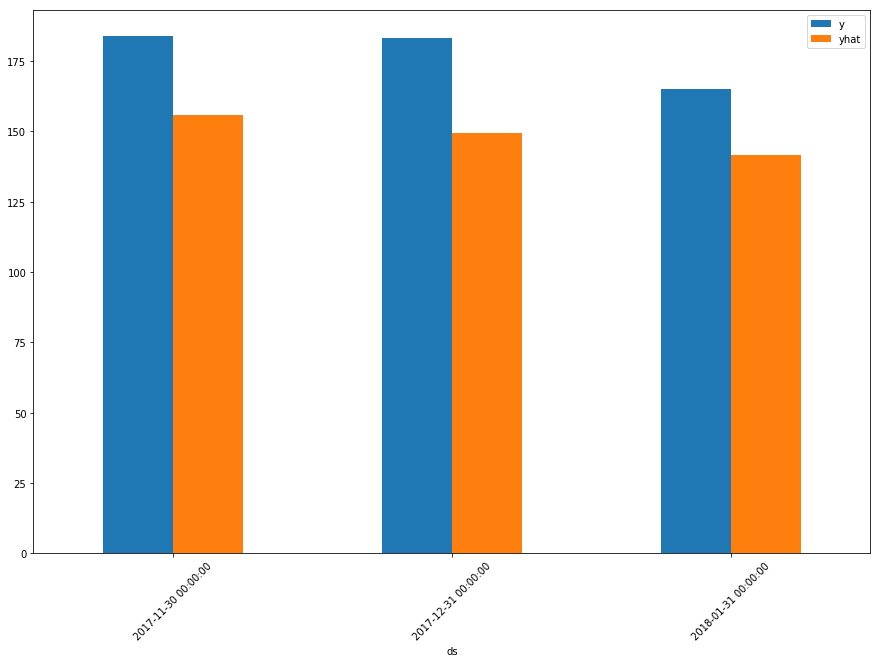

In [39]:
df.plot.bar(rot=45, figsize=(15,10), fontsize=10)

In [33]:
mean_absolute_error(df.yhat.values, df.y.values)

29.73157849566745